In [1]:
#Python Implementation of the Hartree Fock Method
#Procedures listed in the code follow as described in Modern Quantum Chemistry: Introduction to Advanced Electronic Structure Theory, By Attila Szabo and Neil S. Ostlundimport math
import numpy as np
from molecule import atom
from molecule import vector
from molecule import guassian
from molecule import molecule
from notebookImporter import importNotebook

#import integrals notebook for the hartree method
integrals = importNotebook("hartree_integrals")

#define constants 
MIN_ITERATIONS = 2
SCF_CONVERGENCE = pow(10, -20)

#Step 1
#Specify Molecules, Nuclear Coordinates, and Charge of the nucli Number of Electrons,

#generate an h2 atom with a distance of 1.4 AU to compare with Szabo pg. 175
h2 = molecule()
h2.addAtom(atom(vector(9,9,10.4), 1, 1))
h2.addAtom(atom(vector(9,9,9), 1, 1))
#h2.addAtom(atom(vector(9,9,11),1,1))
h2.addBasis("STO-3G")
#and a basis set, for now will add default basis of STO-3G for hydrogen to all atoms


********()())()()()()()()
********()())()()()()()()


[[0.99999999 0.6593182 ]
 [0.6593182  0.99999999]]

[[0.76003188 0.23645465]
 [0.23645465 0.76003188]]

[[-1.22661372 -0.5974173 ]
 [-0.5974173  -0.65382715]]
[[-0.65382715 -0.5974173 ]
 [-0.5974173  -1.22661372]]
Hamiltonian
[[-1.120409   -0.95837996]
 [-0.95837996 -1.120409  ]]



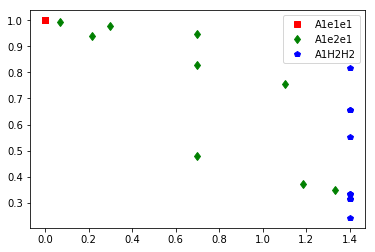

In [2]:
#Step 2
#Calculate Integrals
#Overlap, KE, Nuclear Attraaction, and electron repulsion
S = integrals.overlap(h2)
print(np.matrix(S))

T = integrals.kineticEnergy(h2)
print()
print(np.matrix(T))

V = integrals.nuclearAttraction(h2)
print()

electronRepulsion = integrals.electronElectronRepulsion(h2)

#convert lists into numpy matrices in order to more easily form the electronic hamiltonian
H = np.matrix(T)

#add in all of the nuclear attractions matricies to the hamiltonian
for nucli in V:
    H += np.matrix(nucli)
    print(np.matrix(nucli))
        
print("Hamiltonian")
print(H)
print()

#print(electronRepulsion[0][0][0][0])
#print(electronRepulsion[0][0][1][1])
#print(electronRepulsion[1][0][1][1])
#print(electronRepulsion[1][0][1][0])

## Transformation Matrix

<p>
    <br/>
    The transformation matrix $X$ is computed from the atomic orbital overlap matrix $S$, and is used to transform the orbitals from atomic orbitals to molecular orbitals, since the overlap provides the overlap of atomic orbitals and thus strength of any molecular orbitals that have formed. The transformation matrix is obtained by orthagnolization of the basis is performed through the <i>Canonical Orthogonalization</i> method which uses the following equation:  
    
   $$X_{ij} = \frac{U_{ij}}{s^{1/2}_j}   $$
   $U_{ij}$ refers to a the eigen vector matrix of the $S$, while $s_j$ refers to the eigen values of the overlap matrix. Numpy is utilized in the diagnolization of $S$.

Szabo Pg. 31, 188

</p>    


In [3]:
#Step 3
#Dignolize Overlap Matrix and obtain transformation matrix X

#get size of matricies that need to be generated
size = len(S)

#create transformation matrix of sizexsize
X = np.zeros([size, size])

eigenValues, eigenVector = np.linalg.eig(S)
print(eigenVector)
#compute the transformation matrix X
X = eigenVector * (eigenValues ** (-0.5))

#should print an identity matrix if transformation matrix is correctly computed
print(X.transpose() * np.matrix(S) * X)
print(X)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[[1. 0.]
 [0. 1.]]
[[ 0.54893404 -1.21146408]
 [ 0.54893404  1.21146408]]


In [4]:
#Step 4
#Obtain guess Density matrix, P

#ignore all electron electron interactions,
#and use the core electronic hamiltonan as a guess for the fock matrix
#easisest guess, but can be poor in more complicated systems
F = np.matrix(H)

print("Fock Matrix:")
print(F)
print()

#transform Fock matrix to MO basis
F = X.transpose() * F * X

print("Transformed Fock Matrix:")
print(F)
print()

#diagnolize the Fock Matrix
eigenValues, eigenVectors = np.linalg.eig(F)
print("F` Eigen Values:")
print(eigenValues)
print("F` EigenVector")
print(eigenVectors)
print()

#compute the AO basis orbital coefficents
C = X * eigenVectors

#compute the density matrix
P = np.zeros([size, size])

for index1 in range(size):
    for index2 in range(size):
        
        #this portion undertakes the assumption that the molecule is closed shell
        #other wise the calculation will contain error
        for a in range(int(h2.N / 2)):
            P[index1, index2] += 2 * C[index1, a] * C[index2, a]

print("Electron Density:")
print(P)

Fock Matrix:
[[-1.120409   -0.95837996]
 [-0.95837996 -1.120409  ]]

Transformed Fock Matrix:
[[-1.25279706e+00  6.66133815e-16]
 [ 2.35922393e-16 -4.75602299e-01]]

F` Eigen Values:
[-1.25279706 -0.4756023 ]
F` EigenVector
[[1.00000000e+00 8.57100237e-16]
 [0.00000000e+00 1.00000000e+00]]

Electron Density:
[[0.60265717 0.60265717]
 [0.60265717 0.60265717]]


In [5]:
#Step 5 
#Calculate Contraction of Density Matrix with Electron Repulsion, G Matrix

#generate G matrix a basis-set size by basis-set size matrix
G = np.zeros([size, size])

#iterate over four indicies to handle the four electron integral tensor
for u in range(size):
    for v in range(size):
        for y in range(size):
            for a in range(size):
                
                G[u, v] += P[y][a] * (electronRepulsion[u][v][a][y] - (0.5 * electronRepulsion[u][y][a][v]))
print(G)

[[0.75487165 0.36449458]
 [0.36449458 0.75487165]]


In [6]:
#Step 6
#Calculate Fock matrix, core hamiltonian + G matrix
F = H + G
print(F)

[[-0.36553735 -0.59388537]
 [-0.59388537 -0.36553735]]


In [7]:
#compute the expectation energy of the system

E = 0

#iterate through the Fock matrix, H core, and the electron density 
for u in range(size):
    for v in range(size):
        E += (P[u, v] * ( H[u,v] + F[u,v] ) )
        
E *= 0.5
print(E)


-1.8310000393482846


In [8]:
# SCF Procedure 

E = []
loop = True
while( loop ):
  
    #diagnolze the Fock matrix and convert it to MO basis 
    F = X.transpose() * F * X 
    
    print(F)
    
   #diagnolize the Fock Matrix
    eigenValues, eigenVectors = np.linalg.eig(F)
   # print("F` Eigen Values:")
   # print(eigenValues)
   # print("F` EigenVector")
   # print(eigenVectors)
   # print()

    #compute the AO basis orbital coefficents
    C = X * eigenVectors

    #compute the density matrix
    P = np.zeros([size, size])

    for index1 in range(size):
        for index2 in range(size):
        
            #this portion undertakes the assumption that the molecule is closed shell
            #other wise the calculation will contain error
            for a in range(int(h2.N / 2)):
                P[index1, index2] += 2 * C[index1, a] * C[index2, a]
    
    G = np.zeros([size, size])

    #iterate over four indicies to handle the four electron integral tensor
    for u in range(size):
        for v in range(size):
            for y in range(size):
                for a in range(size):
                
                    G[u, v] += P[y][a] * (electronRepulsion[u][v][a][y] - (0.5 * electronRepulsion[u][y][a][v]))
  
    F = H + G
    
    tempE = 0
    #iterate through the Fock matrix, H core, and the electron density 
    for u in range(size):
        for v in range(size):
            tempE += (P[u, v] * ( H[u,v] + F[u,v] ) )
        
    tempE *= 0.5
    
    E.append(tempE)
    print(tempE)
    
    if(len(E) > 2):
        sizeE = len(E)
        if(abs(E[sizeE-2] - E[sizeE-1]) < SCF_CONVERGENCE):
            loop = False
            


[[-5.78202978e-01  2.22044605e-16]
 [ 4.16333634e-16  6.70267768e-01]]
-1.8310000393482846
[[-5.78202978e-01  2.22044605e-16]
 [ 4.16333634e-16  6.70267768e-01]]
-1.8310000393482846
[[-5.78202978e-01  2.22044605e-16]
 [ 4.16333634e-16  6.70267768e-01]]
-1.8310000393482846


In [9]:
#Step 8
#Diagnolize F' to get C' and E'

In [10]:
#Step 9
#Calculate C from C'

In [11]:
#Step 10
#From P for next iteration of HF Procedure

In [12]:
#Step 11
#Determine if current P is close "enough" to previos P, 
#	if no iterate again start from step 5
#	if yes, then stop iterating, HF procedure completed, and use final C matrix to compute physical properties
